In [115]:
import csv
import numpy as np
from datetime import datetime
import sklearn

In [2]:
import pandas
from pandas import read_csv
from pandas import datetime as p_datetime
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

In [3]:
%matplotlib inline  

# Constants

In [4]:
STATION_ID_COL_NAME = 'station id'
STATION_NAME_COL_NAME = 'station name'
PARAM_T = 'T [°C]'
PARAM_RAIN = 'količina padavin [mm]'

# Initial Configuration

# Utils

In [5]:
def ARSO_datetime_to_epoch(datetime_string):
    """Convert ARSO datetime into epoch time in seconds"""
    utc_time = datetime.strptime(datetime_string, "%Y-%m-%d %H:%M")
    epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
    return epoch_time


def ARSO_datetime_to_epoch_array(datetime_strings):
    """Convert list of ARSO datetimes into epoch time in seconds"""
    return [ARSO_datetime_to_epoch(dt) for dt in datetime_strings]

def convert_slash_into_dot(datetime_string):
    return datetime_string.replace('/', '.')

def borzen_datetime_to_datetime(datetime_string):
    # synchronize all dates
    datetime_string = convert_slash_into_dot(datetime_string)
    # convert to epoch
    try:
        utc_time = datetime.strptime(datetime_string, "%d.%m.%Y %H")
        return utc_time
    except:
        # strptime accepts [0,23] hour interval, while borzen data has [1,24] hour 
        # interval, thus modification of '24' into '00' is needed
        if datetime_string[-2:] == "24":
            datetime_string = datetime_string[:-2] + "00"
            utc_time = datetime.strptime(datetime_string, "%d.%m.%Y %H")
            return utc_time
        else:
            print("Error in datetime parsing: " + datetime_string)

def datetime_to_epoch(datetime_):
    """Convert borzen datetime into epoch time in seconds"""
    epoch_time = (datetime_ - datetime(1970, 1, 1)).total_seconds()
    return epoch_time

# Library

In [6]:
class Station:
    def __init__(self, station_id, station_name, header, data, data_timestamp_epoch):
        self.station_is = station_id
        self.station_name = station_name
        self.header = header
        self.data = data
        self.size = len(data)
        self.data_ts = data_timestamp_epoch
    
    def __str__(self):
        return self.station_id + " " + self.station_name + " size=" + str(self.size)
    
    def __repr(self):
        return self.station_id + " " + self.station_name + " size=" + str(self.size)

In [7]:
class Prices:
    def __init__(self, prices, prices_timestamp_epoch):
        self.prices = prices
        self.timestamps = prices_timestamp_epoch

In [8]:
def test_load_ksedlo():
    """Load weather data for Korenjsko sedlo that has been dowloaded 
    from ARSO website. It removes lines that have any NaN values."""
    print('Start loading korenjsko sedlo')
    import csv
    test_file_ksedlo = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/WeatherDataTest/KorenjskoSedloTest'
    # open file and read content in a csv format
    csvfile = open(test_file_ksedlo, 'r')
    reader = csv.reader(csvfile, delimiter=',')
    data = list(reader)
    # extract header and clean up data by removing empty lines
    header_line = [el.strip() for el in data[0]]
    station_id = header_line[0]
    station_name = header_line[1]
    header = header_line[2:]
    # there are empty lines generated by parsing that needs to be removed
    data_full = data[2:len(data):2]
    data_empty = data[1:len(data):2]
    # check if 'empty' lines are really empty
    for lst in data_empty:
        if len(lst) != 0:
            # there is a non empty line
            print("Warning: not empty line " + lst)
            return None
    # remove station_id column, station_name column and datatime 
    # and create numpy matrix with floats
    data_clean = []
    for line in data_full:
        try:
            line_clean_float = list(map(float, line[3:]))
            data_clean.append(line_clean_float)
        except:
            # lines that have missing values are removed
            pass
    data_clean_np = np.array(data_clean)
    # extract datetime and convert it into timestamp epoch
    data_timestamps = np.array([[ARSO_datetime_to_epoch(line[2])] 
                                for line in data_full])
    # finish
    print('Loading successful')
    return Station(station_id, station_name, header, data_clean_np, data_timestamps)

In [95]:
def test_load_borzen_price_january(b_timestamp = True):
    """Load borzen power prices."""
    print("Load test borzen prices.")
    file_name = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv'
    # open file and read content
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    data = list(reader)
    # get header and clean data
    header = data[7]
    data_clean = data[9:]
    # extract datetime and convert it into timestamp epoch; extract also SIPX values;
    # warning, SIPX values uses comma as decimal marker
    timestamps = []
    prices = []
    for line in data_clean:
        datetime = line[0]
        if b_timestamp:
            datetime = borzen_datetime_to_datetime(datetime)
            datetime = datetime_to_epoch(datetime) 
        timestamps.append(datetime)
        prices.append(float(line[1].strip().replace(",",".")))
    # convert list into numpy array
    timestamps = np.array(timestamps)
    prices = np.array(prices)
    # finish
    print("Loading test borzen prices successful!")
    # TODO 
    return Prices(prices, timestamps)

In [60]:
def load_borzen_table(file_name, b_timestamp = True):
    """Load borzen power prices."""
    file_name_ = file_name.split("/")[-1]
    print("Load " + file_name_)
    # open file and read content
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    data = list(reader)
    # get header and clean data
    header = data[7]
    data_clean = data[9:]
    # extract datetime and convert it into timestamp epoch; extract also SIPX values;
    # warning, SIPX values uses comma as decimal marker
    values = None
    for line in data_clean:
        datetime = line[0]
        if b_timestamp:
            datetime = borzen_datetime_to_datetime(line[0])
            datetime = datetime_to_epoch(datetime)
        price = float(line[1].strip().replace(",","."))
        try:
            values = np.vstack((values, [datetime, price]))
        except:
            # assign directly at the beginning
            values = np.array([datetime, price])
    # finish
    print("Loading prices successful!")
    return np.array(values)

In [39]:
def load_borzen_tables(b_timestamp = True):
    file_names = [
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/01 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/02 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/03 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/04 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/05 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/06 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/07 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/08 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/09 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/10 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/11 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/12 2016-Table 1.csv'
        #'/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv'
    ]
    
    values = None
    for file_name in file_names:
        result = load_borzen_table(file_name, b_timestamp)
        try:
            values = np.vstack((values, result))
        except:
            values = result
    return values

# Load Data

In [12]:
# Load training data ksedlo and power prices
ksedlo_station = test_load_ksedlo()
#consumption = DataLoader.test_load_borzen_consumption()

Start loading korenjsko sedlo
Loading successful


In [13]:
# Check data and remove unnecessary columns
ksedlo_station.data
ksedlo_station.size

1440

# ARIMA 

The example of using ARIMA model in python is described here:
http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [34]:
# Load price data
prices = load_borzen_tables()
prices = Prices(prices[:, 1], prices[:, 0])

Load 01 2016-Table 1.csv
Loading prices successful!
Load 02 2016-Table 1.csv
Loading prices successful!
Load 03 2016-Table 1.csv
Loading prices successful!
Load 04 2016-Table 1.csv
Loading prices successful!
Load 05 2016-Table 1.csv
Loading prices successful!
Load 06 2016-Table 1.csv
Loading prices successful!
Load 07 2016-Table 1.csv
Loading prices successful!
Load 08 2016-Table 1.csv
Loading prices successful!
Load 09 2016-Table 1.csv
Loading prices successful!
Load 10 2016-Table 1.csv
Loading prices successful!
Load 11 2016-Table 1.csv
Loading prices successful!
Load 12 2016-Table 1.csv
Loading prices successful!


In [35]:
prices.prices

array([ 49.62,  43.5 ,  38.63, ...,  33.02,  33.71,  46.  ])

In [15]:
# generate pandas dataframe with prices and datetimes
d = {'price': prices.prices}
dt = pandas.to_datetime(prices.timestamps, unit = "s")
series = pandas.DataFrame(data=d, index = dt)
series.head()

,price
2016-01-01 01:00:00,49.62
2016-01-01 02:00:00,43.50
2016-01-01 03:00:00,38.63
2016-01-01 04:00:00,36.80
2016-01-01 05:00:00,34.50


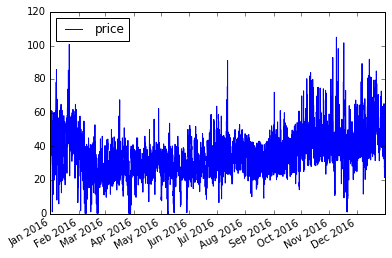

In [16]:
# plot timeseries
series.plot()

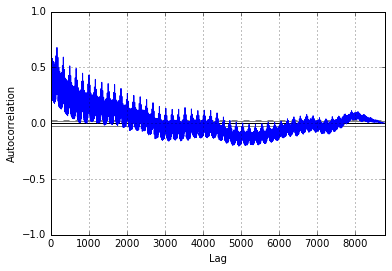

In [17]:
# plot autocorrelation
autocorrelation_plot(series)

In [18]:
# fit ARIMA model and display summary
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 8783
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -27532.093
Method:                       css-mle   S.D. of innovations              5.561
Date:                Sun, 16 Apr 2017   AIC                          55078.187
Time:                        00:44:55   BIC                          55127.751
Sample:                    01-01-2016   HQIC                         55095.073
                         - 12-31-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.635e-06      0.053     -0.000      1.000      -0.103       0.103
ar.L1.D.price     0.0450      0.011      4.234      0.000       0.024       0.066
ar.L2.D.price     0.0498      0.011     

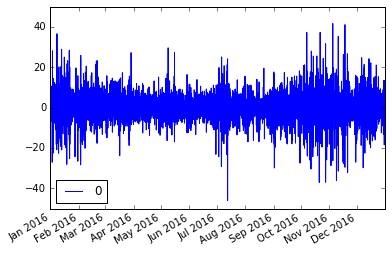

In [19]:
# residuals
residuals = pandas.DataFrame(model_fit.resid)
residuals.plot()

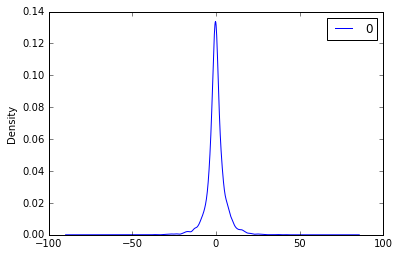

In [20]:
residuals.plot(kind='kde')

In [21]:
# forecast; returns array of forecasts, array of standard error and array of 95% confidence interval
n = 48
fc_group = model_fit.forecast(n)
#print(fc_group)

# extract
fc = fc_group[0]
se = fc_group[1]
ci = fc_group[2]
#print(ci)

In [22]:
# load true values
file_name = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv'
true_values = load_borzen_table(file_name)

Load 01 2017-Table 1.csv
Loading prices successful!


In [23]:
# compare forecast and true values
true_prices = true_values[:n, 1]

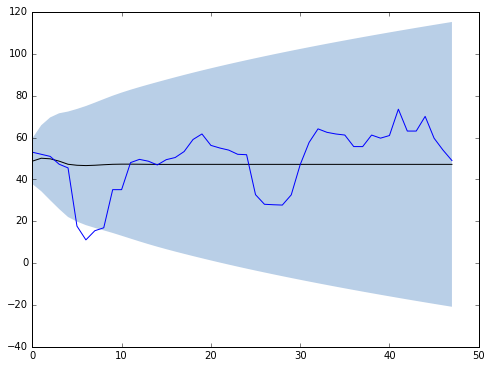

In [24]:
# fig size
fig, ax = pyplot.subplots(figsize=(8,6))

# plot data
x = range(0,len(fc))
ax.plot(x, fc, color = 'black')
ax.plot(x, true_prices, color = 'blue')

# plot confidence interval
ci_bottom = ci[:,0]
ci_top = ci[:,1]
ax.fill_between(x, ci_top, ci_bottom, color='#b9cfe7', edgecolor='')

# Neural Networks

In [89]:
# split datetime into hours, days, weekdays, months
def split_datetime(timestamps):
    nn_datetime_np = np.array([])
    for nn_datetime in timestamps:
        nn_datetime = borzen_datetime_to_datetime(nn_datetime)
        tmp_arr = [nn_datetime.hour, nn_datetime.day, nn_datetime.weekday(), nn_datetime.month]
        try:
            nn_datetime_np = np.vstack((nn_datetime_np, tmp_arr))
        except:
            nn_datetime_np = np.array(tmp_arr)
    return nn_datetime_np

## Load data

In [62]:
# load price data
prices_nn = load_borzen_tables(False)
prices_nn = Prices(prices_nn[:, 1], prices_nn[:, 0])

Load 01 2016-Table 1.csv
Loading prices successful!
Load 02 2016-Table 1.csv
Loading prices successful!
Load 03 2016-Table 1.csv
Loading prices successful!
Load 04 2016-Table 1.csv
Loading prices successful!
Load 05 2016-Table 1.csv
Loading prices successful!
Load 06 2016-Table 1.csv
Loading prices successful!
Load 07 2016-Table 1.csv
Loading prices successful!
Load 08 2016-Table 1.csv
Loading prices successful!
Load 09 2016-Table 1.csv
Loading prices successful!
Load 10 2016-Table 1.csv
Loading prices successful!
Load 11 2016-Table 1.csv
Loading prices successful!
Load 12 2016-Table 1.csv
Loading prices successful!


## Fit the model 

In [83]:
# change type of prices from string to float
y = prices_nn.prices.astype(float)

In [124]:
# determine X
X = split_datetime(prices_nn.timestamps)
# standardize
X = sklearn.preprocessing.scale(X)
pca = sklearn.decomposition.PCA(n_components=4)
pca.fit(X)
print(pca.explained_variance_ratio_) 

[ 0.25161611  0.25047324  0.25        0.24791064]


/Users/ales/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [126]:
model = sklearn.neural_network.MLPRegressor()

In [127]:
model_fit = model.fit(X, y)

/Users/ales/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


## Predict

In [99]:
test_prices = test_load_borzen_price_january(False)

Load test borzen prices.
Loading test borzen prices successful!


In [128]:
P = sklearn.preprocessing.scale(split_datetime(test_prices.timestamps))

/Users/ales/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [129]:
predicted = model_fit.predict(P)

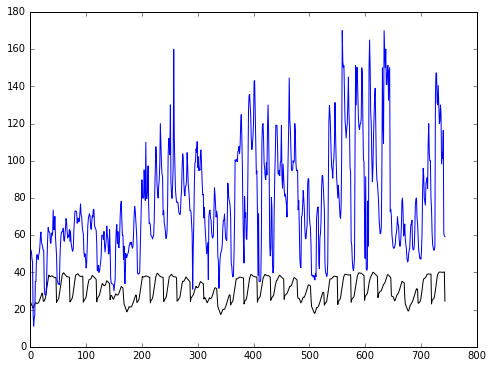

In [130]:
# fig size
fig, ax = pyplot.subplots(figsize=(8,6))

# plot data
x = range(0,len(test_prices.prices))
true_prices = test_prices.prices
ax.plot(x, predicted, color = 'black')
ax.plot(x, true_prices, color = 'blue')